# Praca domowa z ML numer 12

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/NLP_attention/homework_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import json
import seaborn as sns
import numpy as np
import gensim.downloader as api
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
import requests
from sklearn.metrics.pairwise import cosine_similarity

## Przygotowanie słów

In [22]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/NLP_attention/semantic_classes.json"

response = requests.get(url)
response.raise_for_status()

semantic_classes = response.json()

#przykładowe słowa 

for key in semantic_classes.keys():
    print(f"{key.upper()}: ", semantic_classes.get(key))

GENDER:  [['king', 'queen'], ['man', 'woman'], ['prince', 'princess'], ['waiter', 'waitress'], ['actor', 'actress'], ['husband', 'wife'], ['father', 'mother']]
VERB_TENSE:  [['bring', 'brought'], ['get', 'got'], ['like', 'liked'], ['swim', 'swam'], ['eat', 'ate'], ['drive', 'drove'], ['sing', 'sang']]
SINGULAR_PLURAL:  [['cat', 'cats'], ['dog', 'dogs'], ['car', 'cars'], ['child', 'children'], ['mouse', 'mice'], ['person', 'people'], ['foot', 'feet']]
COUNTRY_CAPITAL:  [['France', 'Paris'], ['Italy', 'Rome'], ['Germany', 'Berlin'], ['Japan', 'Tokyo'], ['Spain', 'Madrid'], ['Canada', 'Ottawa'], ['Australia', 'Canberra']]
COMPARATIVE:  [['bright', 'brighter'], ['big', 'bigger'], ['small', 'smaller'], ['fast', 'faster'], ['slow', 'slower'], ['high', 'higher'], ['low', 'lower']]
SUPERLATIVE:  [['big', 'biggest'], ['small', 'smallest'], ['fast', 'fastest'], ['slow', 'slowest'], ['high', 'highest'], ['low', 'lowest'], ['bright', 'brightest']]
JOB_TOOL:  [['carpenter', 'hammer'], ['painter', '

## Embedding

Korzystam z dostępnego modelu wpomninanego w zadaniu - dokładniej GloVe. Nie jest to najdokładniejszy model, ale zapewnia dostatecznie dobre wyniki. Można rozpatrzeć jeszcze BERT i Word2Vec, ale oba są duże i na potrzeby zadania zdecydowano się wykorzystać i tak już dobry GloVe.

###### poniższe wykonuje się ~ 30\40 s

In [23]:
model_glove = api.load("glove-wiki-gigaword-100")

In [24]:
#funkcja do pozyskania embeddingów
def get_embeddings(words_list, embedding):
    vectors = []
    labels = []
    for word in words_list:
        vec = embedding[word]
        if vec is not None:
            vectors.append(vec)
            labels.append(word)
            

    return np.array(vectors), labels

In [25]:
#zapisanie wyrazów do odpowiedniego formatu

#chcemy mieć poprawnie zapisane ze słownika w inny sensowny datatype
listed_words = []
all_words_class = []
for key, pairs in semantic_classes.items():
    for a, b in pairs:
        listed_words.append(a.lower())
        all_words_class.append(key)
        listed_words.append(b.lower())
        all_words_class.append(key)


### Globalne PCA

In [26]:
#dosatejmy embedding
all_vectors, all_labels = get_embeddings(listed_words, model_glove)

In [27]:
#przypisanie każdemu wyrazowi kalsy, aby potem lepiej zwizualizować to na obrazkach <- czysto wizualne zastosowanie
classes = list(semantic_classes.keys())
num_classes = len(classes)
cmap = plt.get_cmap("tab10")
#przypisujemy kolorki dla każdej klasy
class_colors = {cls: cmap(i % num_classes) for i, cls in enumerate(classes)}

#kolorki do wykresów
colors = [class_colors[classified] for classified in all_words_class]

In [28]:
#pca i skalowanie wektorów
pca = PCA(n_components = 2)
scaler = StandardScaler()

data = scaler.fit_transform(all_vectors)
data_pca = pca.fit_transform(data)

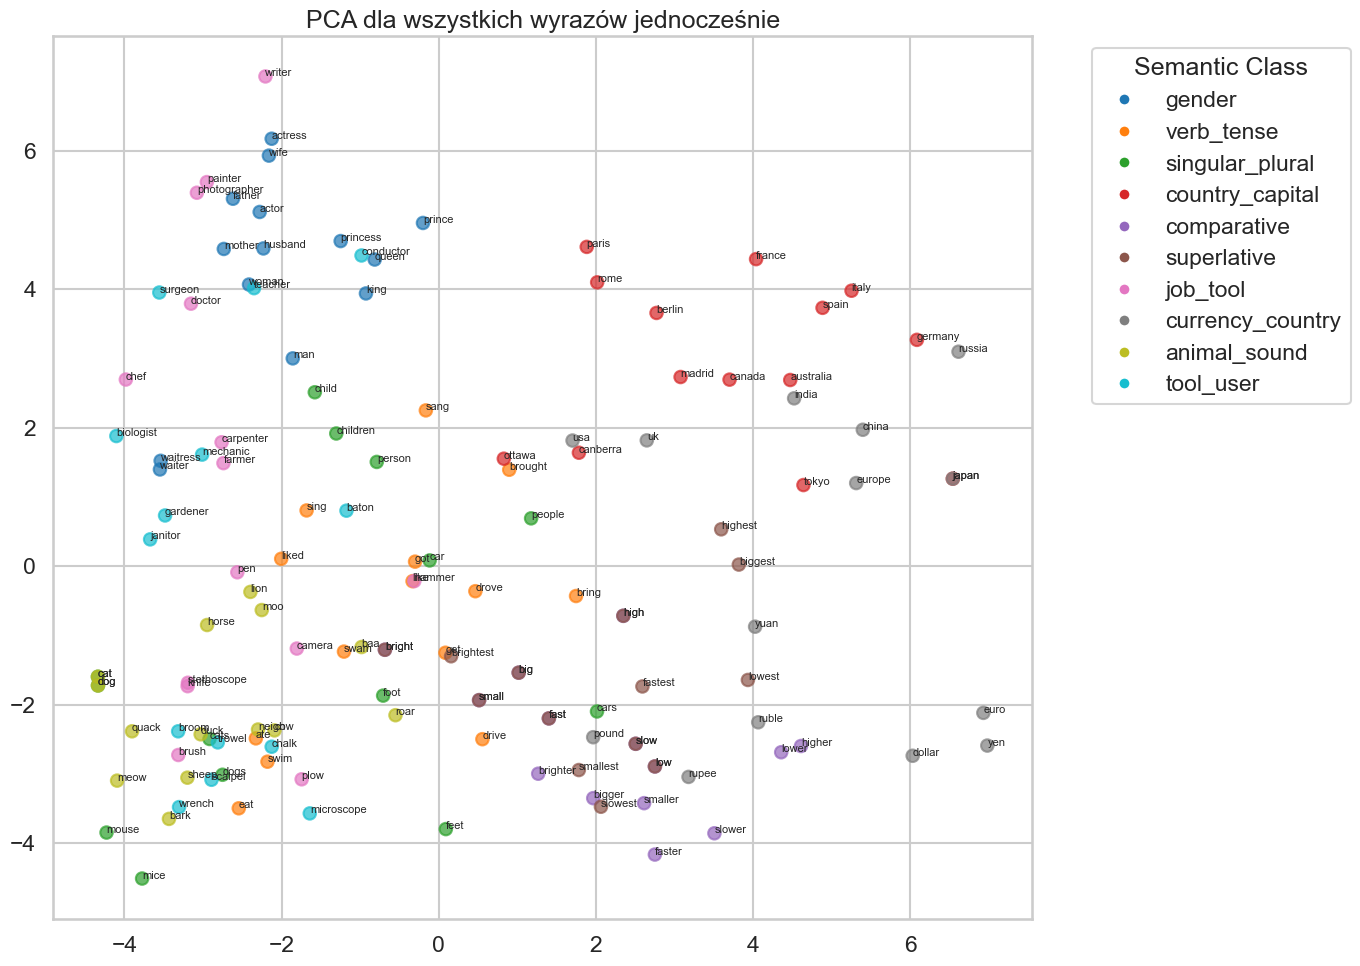

In [29]:
#plotowanie - globalne PCA, jeden wykres
sns.set(style="whitegrid", context="talk", palette="colorblind")
plt.figure(figsize=(14, 10))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=colors, alpha=0.7)
for i, label in enumerate(all_labels):
    plt.text(data_pca[i, 0], data_pca[i, 1], label, fontsize=8)

handles = [plt.Line2D([0], [0], marker='o', color='w', label=cls, markerfacecolor=class_colors[cls], markersize=8)
           for cls in classes]
plt.legend(handles=handles, title="Semantic Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("PCA dla wszystkich wyrazów jednocześnie")
plt.grid(True)
plt.tight_layout()

## Dyskusja

Zastosowanie (globalnego) PCA pokazuje, że słowa należące do tej samej klasy semantycznej często pozostają blisko siebie. Najwyraźniej widać to na przykładzie klasy „płeć”, gdzie wszystkie wyrazy tworzą zwartą grupę. Największy rozrzut obserwujemy natomiast w klasie „liczba pojedyncza / mnoga”, co jest zrozumiałe – zwłaszcza w przypadku słów takich jak „child”, „person”, „children”, które często niosą ze sobą dodatkowe informacje (lub ich oczekują), np. płciowe.

Podsumowując, na podstawie tylko powyższego można wysnuć, że PCA częściowo zachowuje istotne kierunki semantyczne. Najlepiej widoczne jest to w klasie „płeć”, której elementy pozostają blisko siebie, co świadczy o językowym sensie ich reprezentacji wektorowej. Z kolei klasa „liczba pojedyncza / mnoga” wykazuje duży rozrzut — być może dlatego, że niektóre wyrazy (np. „child”, „children”) silniej należą do innych kategorii semantycznych.

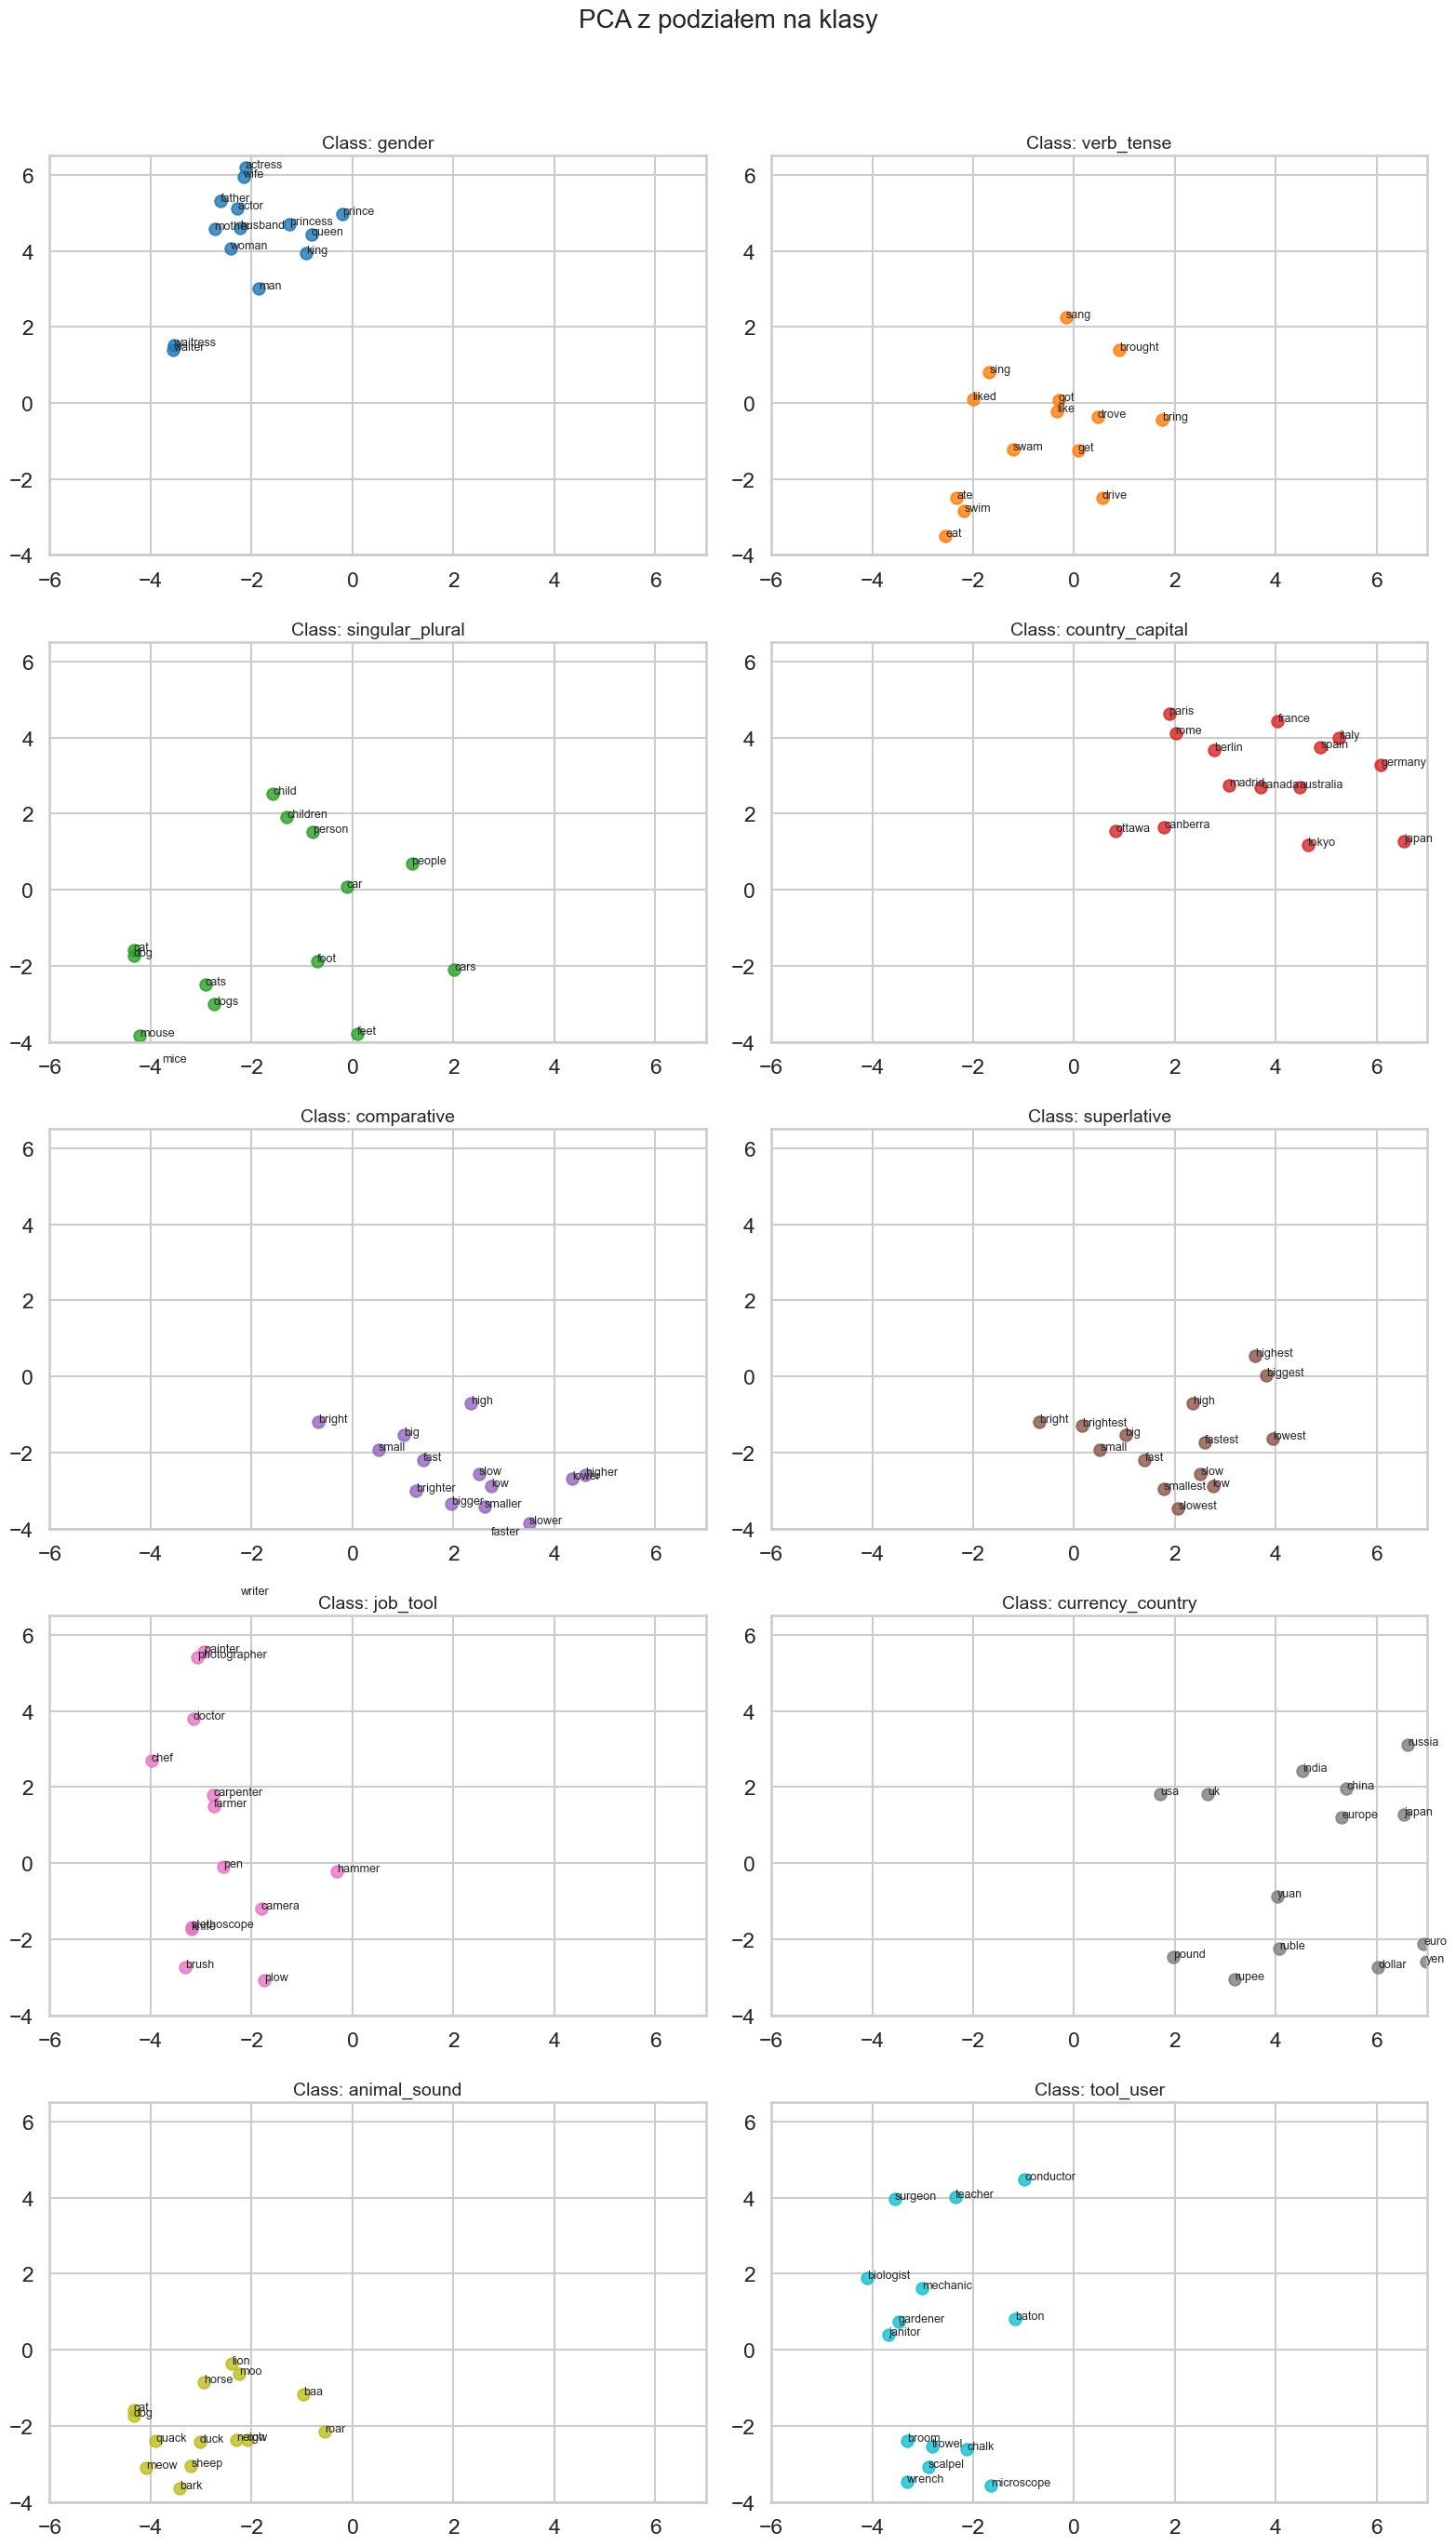

In [30]:
#tworzymy 10 subplotów tak, aby podzielić na klasy

class_to_points = {cls: [] for cls in classes}
class_to_labels = {cls: [] for cls in classes}

for i, (word, cls) in enumerate(zip(listed_words, all_words_class)):
    class_to_points[cls].append(data_pca[i])
    class_to_labels[cls].append(word)

# Plottowanie
sns.set(style="whitegrid", context="talk", palette="colorblind")
fig, axes = plt.subplots(5, 2, figsize=(16, 28))
axes = axes.flatten()

for i, cls in enumerate(classes):
    ax = axes[i]
    points = np.array(class_to_points[cls])
    labels = class_to_labels[cls]
    color = class_colors[cls]

    ax.scatter(points[:, 0], points[:, 1], color=color, alpha=0.8)
    for j, label in enumerate(labels):
        ax.text(points[j, 0], points[j, 1], label, fontsize=9)
    ax.set_xlim(-6, 7)
    ax.set_ylim(-4,6.5)
    ax.set_title(f"Class: {cls}", fontsize=14)
    ax.grid(True)

plt.suptitle("PCA z podziałem na klasy", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Ta przynależność do różnych klas semantycznych jednocześnie jest jeszcze wyraźniejsza gdy przyjrzymy się poszcególnym klasom osobno.
Dla niektórych z nich semantyczna spójność jest dobrze zachowana po redukcji wymiarów — dotyczy to np. klas „gender”, „animal_sound”, „superlative” i „country_capital”. Ma to sens również pod względem językowym — wyrazy te często współwystępują w podobnych kontekstach.

Zaskakująco słabo zachowała się klasa „job_tool”. Przykładowo „painter” i „photographer” były bliżej słów z klasy „gender”, co może mieć uzasadnienie — zawody bywają kojarzone z konkretną płcią. Podobna sytuacja miała miejsce w klasie „singular_plural”, gdzie np. „child” i „children” były rozproszone.

##### `Czy można zatem powiedzieć, że PCA zachowuje przynależność do klasy semantycznej?`

Moim zdaniem — nie do końca. Przedstawione wcześniej przykłady pokazują, że niektóre klasy ulegają wymieszaniu. Bez kolorystycznego oznaczenia trudno byłoby je rozróżnić. Gdyby liczba analizowanych słów była większa, zróżnicowanie prawdopodobnie byłoby jeszcze bardziej widoczne. Aby dokładniej odpowiedzieć na to pytanie, warto przyjrzeć się PCA zastosowanemu osobno dla każdej klasy, co zostało opisane poniżej.

### Osobne PCA dla każdej klasy


In [31]:
# grupowanie wektorów względem klasy (tzn każdy wyraz trafia do swojej klasy)
class_to_vectors = defaultdict(list)
class_to_words = defaultdict(list)

#każdemu wyrazowi odpowiada embedding
for word, vec, cls in zip(listed_words, all_vectors, all_words_class):
    class_to_words[cls].append(word)
    class_to_vectors[cls].append(vec)

#teraz będzimy chcieli zastosować PCA, dla każdej klasy osobno
class_to_pca_points = {}

#stosujemy pca dla każdej klasy (wraz ze skalowaniem)

for cls in class_to_vectors:
    vecs = np.array(class_to_vectors[cls])
    scaler = StandardScaler()
    vecs_scaled = scaler.fit_transform(vecs)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vecs_scaled)

    class_to_pca_points[cls] = pca_result

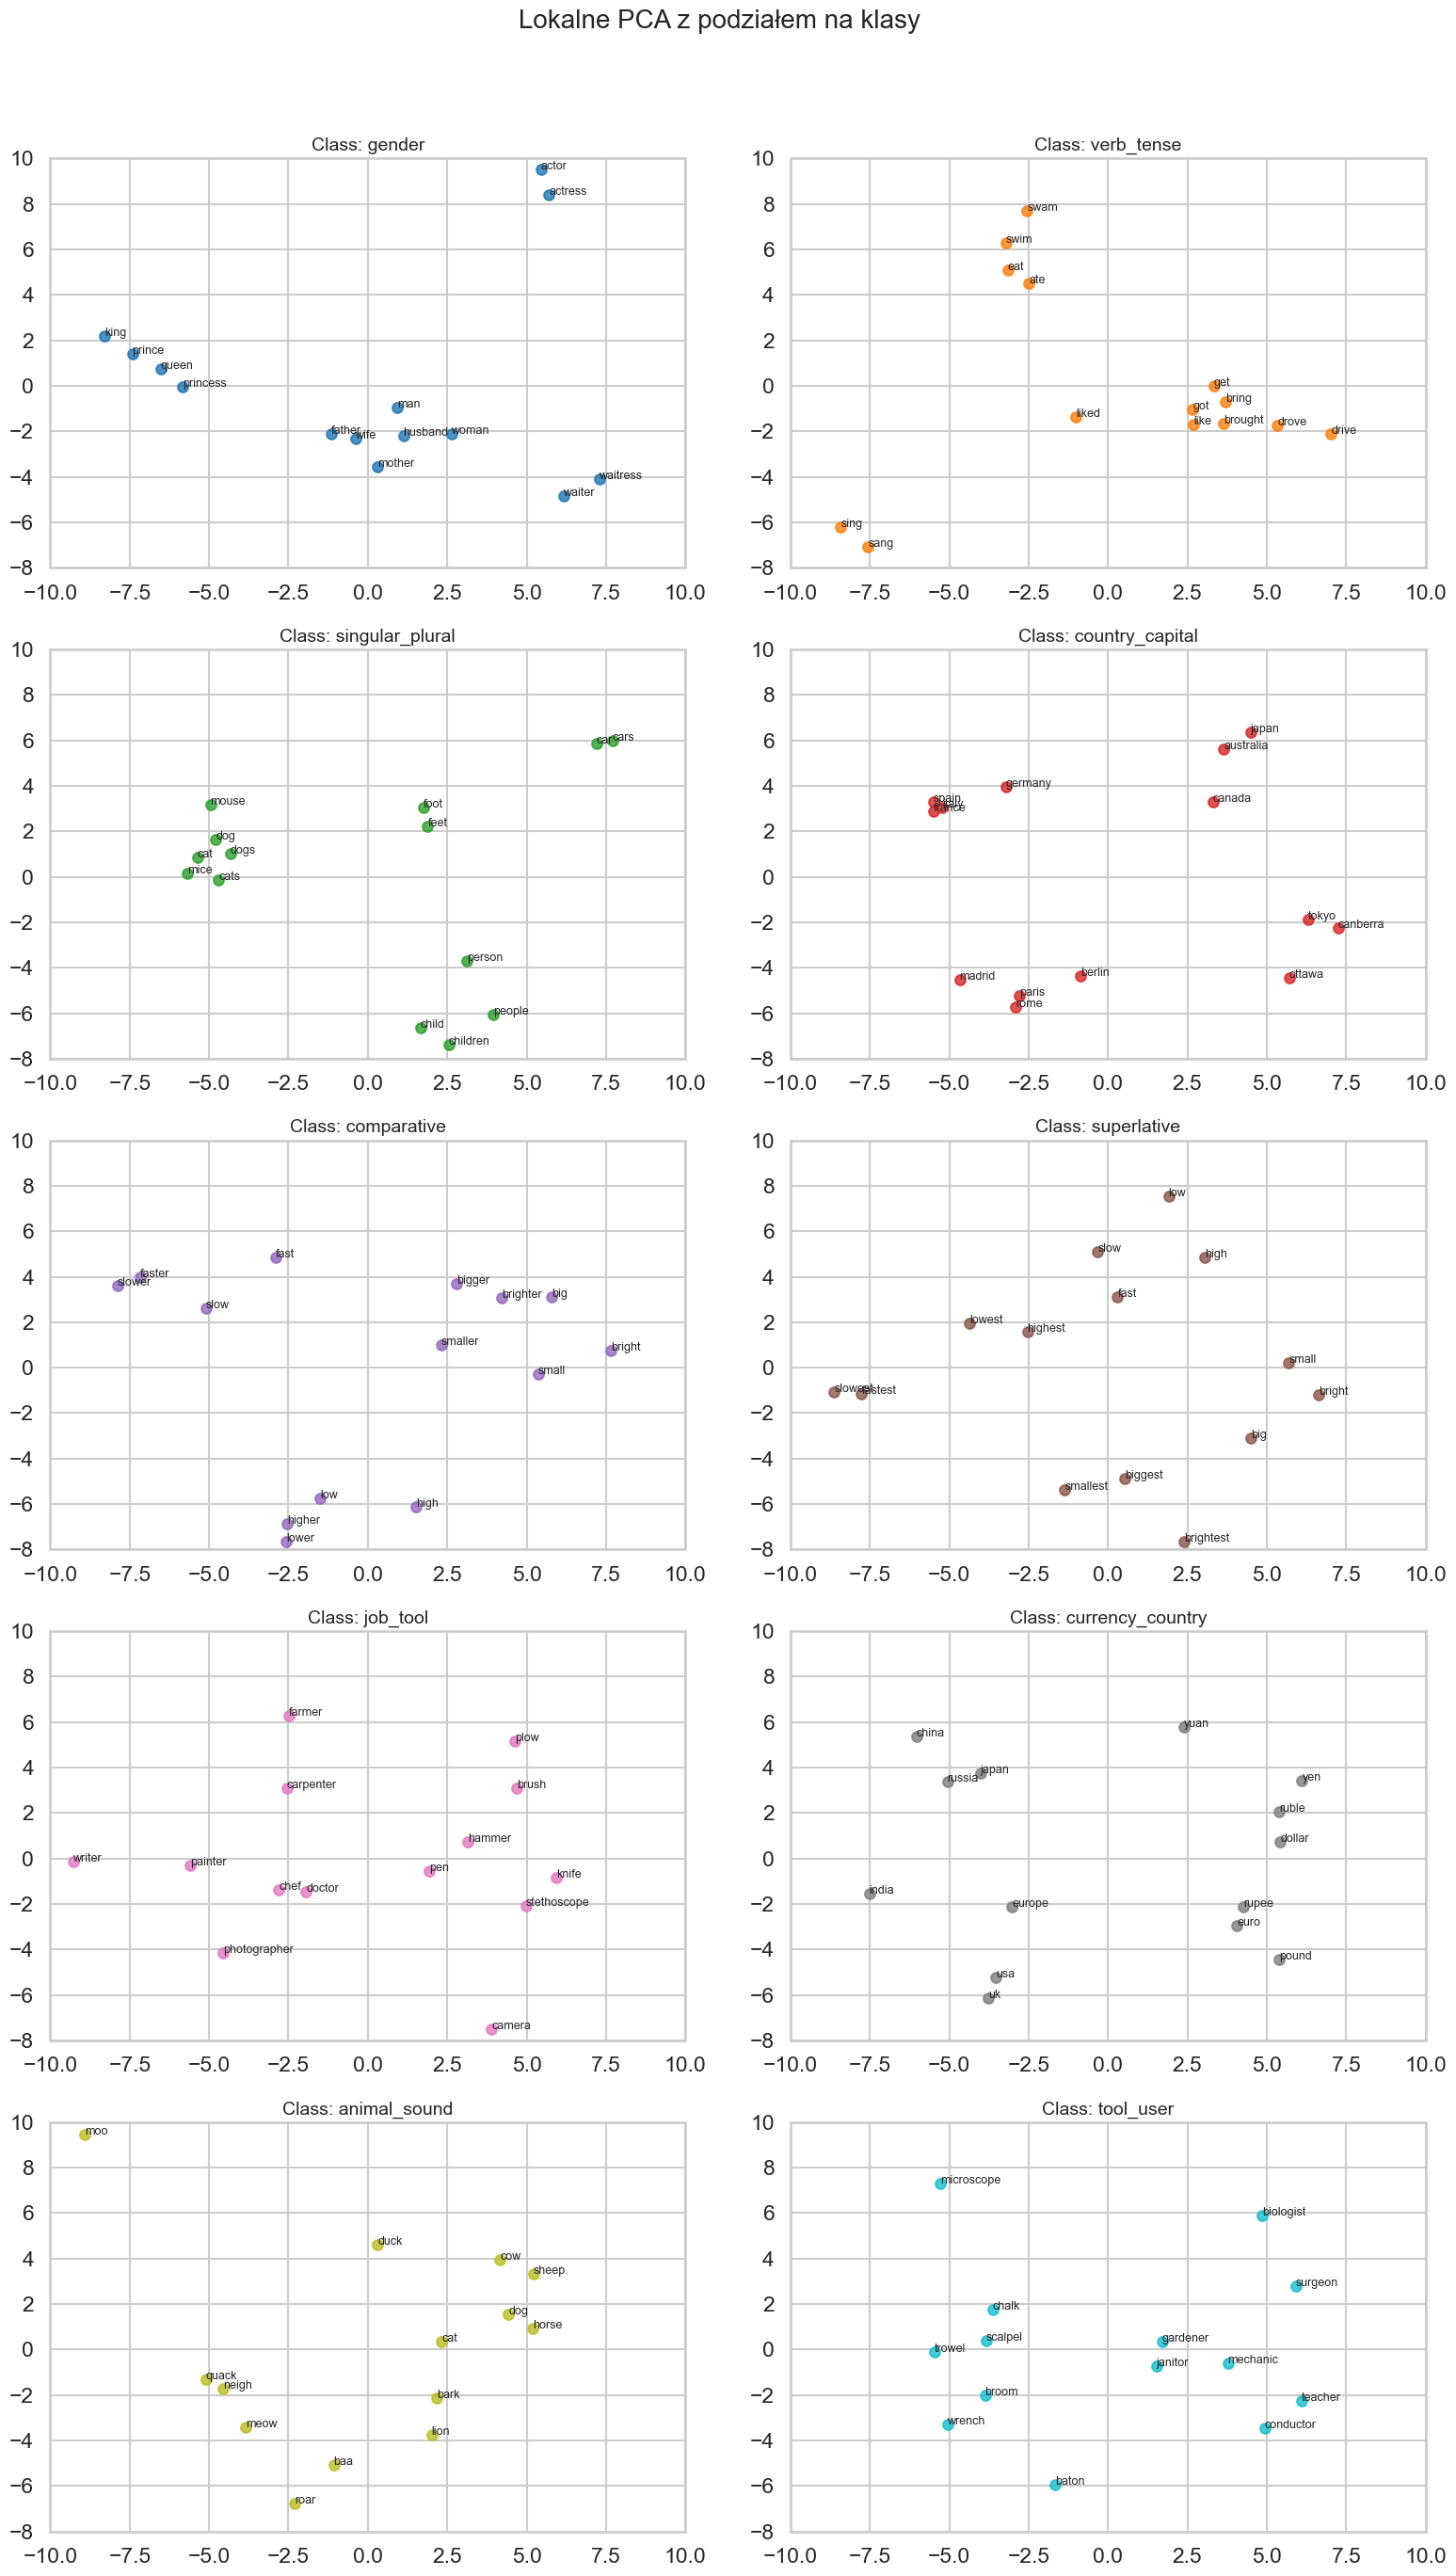

In [38]:
#wizualizcaja osobnego PCA dla każdej klasy
sns.set(style="whitegrid", context="talk", palette="colorblind")
fig, axes = plt.subplots(5, 2, figsize=(16, 28))
axes = axes.flatten()

for i, cls in enumerate(classes):
    ax = axes[i]
    points = class_to_pca_points[cls]
    labels = class_to_labels[cls]
    color = class_colors[cls]

    ax.scatter(points[:, 0], points[:, 1], color=color, alpha=0.8, s=60)
    for j, label in enumerate(labels):
        ax.text(points[j, 0], points[j, 1], label, fontsize=9)

    ax.set_title(f"Class: {cls}", fontsize=14)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-8,10)
    ax.grid(True)

# Układ końcowy
plt.suptitle("Lokalne PCA z podziałem na klasy", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Zastosowanie PCA dla każej klasy osobno pozwala łatwiej zauważyć różnice w strukturze wektorów. W klasie „gender” pojawiają się np. wyrazy takie jak „king”, „queen”, „prince”, „princess” — potencjalnie przynależące także do klasy „royalty”, a także „actor” i „actress”, które mogłyby należeć do klasy „theatre”. 

Warto zawuważyć, że wyrazyw wewnątrz większości klas sematycznych są dosyć mocno rozproszone — z wyjątkiem klasy „animal_sound”, w której wiele elementów znajduje się blisko siebie (z wyjątkiem „moo”, co jest nieintuicyjne i trudne do wyjaśnienia - nie do końca rozumiem dlaczego tak jest).

Wobec powyższych wydaje mi się, że łatwiej wysnuć wniosek, że redukcja wymiarów nie gwarantuje zachowania semantycznej spójności klas (co zdają się potwierdzać wizualizacje).

# Arytmetyka Embeddingu

Słowa wybrane do "odjęcia" - po jednym dla każdej klasy stosując podejście
```
embedding(B) - embedding(A) + embedding(C),
```

gdzie B pochodzi z wektora słów nam znanych, a A i C określa użytkownik tak aby postarać zbliżyć się do oczekiwanego słowa, dla którego B jest parą w naszym zadaniu

In [33]:
#słowa
#słowo B to będzie zawsze pierwsze słowo z grupy (danej klasy)

words_A = [
    "man", "present", "singular","country", "light", "big", "profession", "country", "animal", "tool" 
]

words_C = [
    "woman", "past", "plural", "capital","lighter","bigger", "tool", "currency", "sound", "profession"  
]

### Zastosowanie odległości euklidesowej

#### Uwaga: poniższe liczy się ~20 s

In [34]:
# Docelowa tabela
results = []

# Przechodzimy przez klasy i jedną parę z danej klasy
for idx, (cls, pairs) in enumerate(semantic_classes.items()):

    A = words_A[idx].lower()
    C = words_C[idx].lower()
    B = pairs[0][0].lower()  # bierzemy pierwsze z każdej pary (czyli np, king)
    D = pairs[0][1].lower()  #docelowe słowo
    #biezremy embedding dla tych słów
    vecA = model_glove[A]
    vecB = model_glove[B]
    vecC = model_glove[C]

    # arytemtyka na embeddingach zgodnie z tym co było w poleceniu
    result_vec = vecB - vecA + vecC

    # Liczymy odległość euklidesową
    all_words = np.array(list(model_glove.key_to_index.keys()))
    all_embs = np.array([model_glove[word] for word in all_words])
    distances = euclidean_distances([result_vec], all_embs)[0] # funkcja z sklearn

    # Nie chcemy patrzeć czy słowa, które uzyliśmy są najbliże, więc je wyrzucamy
    mask = ~np.isin(all_words, [A, B, C])
    filtered_words = all_words[mask]
    filtered_dists = distances[mask]

    # 5 cnajbliższych
    top_indices = np.argsort(filtered_dists)[:5]

    #ich odległości
    closest_words = [(filtered_words[i], round(filtered_dists[i], 3)) for i in top_indices]

    # Dodajmy wiersz dla podanej klasy z uzsyanymi wyrazami oraz ich odległościami
    row = [cls, B, A, C, D] + [f"{word} ({dist: .4f})" for word, dist in closest_words]
    results.append(row)

#docelowa tabelka
columns = ["Klasa semantyczna", "Dane słowo", "A", "C", "docelowe słowo", "Najbliższe", "Drugie najbliższe", "Trzecie najbliższe", "Czwarte najbliższe", "Piąte najbliższe"]
df = pd.DataFrame(results, columns=columns)

In [35]:
print(df.to_markdown(index=False))

| Klasa semantyczna   | Dane słowo   | A          | C          | docelowe słowo   | Najbliższe           | Drugie najbliższe   | Trzecie najbliższe   | Czwarte najbliższe   | Piąte najbliższe   |
|:--------------------|:-------------|:-----------|:-----------|:-----------------|:---------------------|:--------------------|:---------------------|:---------------------|:-------------------|
| gender              | king         | man        | woman      | queen            | queen ( 4.0810)      | monarch ( 4.6430)   | throne ( 4.9060)     | elizabeth ( 4.9220)  | prince ( 4.9810)   |
| verb_tense          | bring        | present    | past       | brought          | put ( 5.0910)        | back ( 5.1290)      | away ( 5.1780)       | pushed ( 5.2160)     | push ( 5.2230)     |
| singular_plural     | cat          | singular   | plural     | cats             | dog ( 4.5930)        | puppy ( 4.7950)     | cats ( 4.9950)       | monkey ( 5.1550)     | rabbit ( 5.1670)   |
| country_capital   

Zauważalne jest, że przy użyciu odległości euklidesowej najlepiej zachowała się klasa „gender” — uzyskaliśmy klasyczny przykład
```
embedding("queen") ≈ embedding("king") - embedding("man") + embedding("woman")
```
Pozostałe słowa w zestawieniu również miały sens semantyczny (np. skojarzenia z monarchią czy królową Elżbietą). Warto w tym kontekście wrócić do wcześniejszej obserwacji — „king”, „queen”, „prince” itd. mogą również należeć do klasy „royalty”, co tłumaczy ich położenie w przestrzeni PCA.

Zupełnie inaczej było w klasie „tool_user”. Dla kombinacji
```
embedding("broom") - embedding("tool") + embedding("profession")
```
nie uzyskano nawet słowa „janitor” nawet w top 5 najbliższych wyrazów. Podobnie problematyczna okazała się klasa „country_currency” — mimo oczywistego związku USA i dolara, w top 5 znalazło się np. „HSBC”. Możliwe, że wynika to ze zbyt ogólnych pośrednich słów („country” i „currency”).
Ciekawe jest też, że uzyskaliśmy także
 ```
embedding("dog") ≈ embedding("cat") - embedding("singular") + embedding("plural").
```
Niemniej jako trzecie słowo udało się uzsykać docelowe "cats". 

W dalszej części zastosowano  również „cosine similarity” zamiast odległości euklidesowej, aby porównać obie metody.


### Zastosowanie podobieństwa cosinusów

In [36]:
# Docelowa tabela
results = []

# Przechodzimy przez klasy i jedną parę z danej klasy
for idx, (cls, pairs) in enumerate(semantic_classes.items()):
    if not pairs:
        continue

    A = words_A[idx].lower()
    C = words_C[idx].lower()
    B = pairs[0][0].lower()  # dane słowo
    D = pairs[0][1].lower()  # docelowe słowo

    # Bierzemy embeddingi dla tych słów
    vecA = model_glove[A]
    vecB = model_glove[B]
    vecC = model_glove[C]

    # Arytmetyka na embeddingach zgodnie z tym co było w poleceniu
    result_vec = vecB - vecA + vecC

    # Liczymy cosine similarity
    all_words = np.array(list(model_glove.key_to_index.keys()))
    all_embs = np.array([model_glove[word] for word in all_words])
    similarities = cosine_similarity([result_vec], all_embs)[0]  # shape: (vocab_size,)

    # Nie chcemy patrzeć czy słowa, które użyliśmy są najbliższe, więc je wyrzucamy
    mask = ~np.isin(all_words, [A, B, C])
    filtered_words = all_words[mask]
    filtered_sims = similarities[mask]

    # 5 najbliższych (największe podobieństwo)
    top_indices = np.argsort(filtered_sims)[-5:][::-1]

    # Ich podobieństwa
    closest_words = [(filtered_words[i], round(filtered_sims[i], 4)) for i in top_indices]

    # Dodajemy wiersz do tabeli
    row = [cls, B, A, C, D] + [f"{word} ({sim: .4f})" for word, sim in closest_words]
    results.append(row)

# Docelowa tabelka
columns = ["Klasa semantyczna", "Dane słowo", "A", "C", "Docelowe słowo", "Najbliższe", "Drugie najbliższe", "Trzecie najbliższe", "Czwarte najbliższe", "Piąte najbliższe"]
df = pd.DataFrame(results, columns=columns)

In [37]:
# Wyświetlenie
print(df.to_markdown(index=False))

| Klasa semantyczna   | Dane słowo   | A          | C          | Docelowe słowo   | Najbliższe           | Drugie najbliższe    | Trzecie najbliższe   | Czwarte najbliższe   | Piąte najbliższe     |
|:--------------------|:-------------|:-----------|:-----------|:-----------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|
| gender              | king         | man        | woman      | queen            | queen ( 0.7834)      | monarch ( 0.6934)    | throne ( 0.6833)     | daughter ( 0.6809)   | prince ( 0.6713)     |
| verb_tense          | bring        | present    | past       | brought          | back ( 0.6975)       | put ( 0.6951)        | away ( 0.6856)       | pushed ( 0.6771)     | push ( 0.6754)       |
| singular_plural     | cat          | singular   | plural     | cats             | dog ( 0.6996)        | puppy ( 0.6402)      | cats ( 0.6175)       | monkey ( 0.5955)     | rabbit ( 0.5932)     |
| cou

Tu również klasa „gender” zachowała się poprawnie. Dodatkowo w kombinacji
```
embedding("usa") - embedding("country") + embedding("currency")
```
uzyskano „dollar” jako trzecie słowo — co można uznać za sukces. Nadal jednak nie uzyskano oczekiwanego wyniku w przypadku:
```
embedding("broom") - embedding("tool") + embedding("profession")
```
Warto jednak zauważyć, że w naszym przypadku zastosowanie "cosine similarity" dawało z reguły lepsze wyniki niż zastosowanie odległości euklidesowej.

# Podsumowanie

Niektóre klasy semantyczne znacznie lepiej sprawdzają się w zadaniu arytmetyki embeddingów. Najlepszym przykładem jest klasa „gender”, gdzie uzyskano oczekiwany wynik:
```
embedding("queen") ≈ embedding("king") - embedding("man") + embedding("woman").
```
Znacznie gorzej wypadły klasy „country_currency” oraz „tool_user”, gdzie nie udało się uzyskać oczekiwanych słów — czasem nawet nie pojawiły się one w top 5.

Widać wyraźnie, że niektóre relacje semantyczne są lepiej reprezentowane w przestrzeni embeddingowej. Przykładowo: płeć czy stolice państw mają zwykle jednoznaczne przyporządkowanie, co sprzyja ich „geometrycznemu" odwzorowaniu. Z kolei zawody czy dźwięki zwierząt mogą mieć wiele skojarzeń i różne konteksty, co powoduje rozproszenie reprezentacji, co widzieliśmy też wcześniej, gdy przeprowadzaliśmy PCA.

Ciekawy był przypadek:
```
embedding("cat") - embedding("singular") + embedding("plural")
```
który zamiast „cats” dał jako wynik „dog” — i to w liczbie pojedynczej. Pokazuje to, że nawet pozornie prostą relację (liczba mnoga) nie zawsze da się łatwo odwzorować w embeddingach. Tak samo jest w przypadku psa i szczekania. Dla człowieka jest to jasne, że pies szczeka, ale dog - animal + sound niekoniecznie musi być jednoznacznie przypisany tylko do szczekania, bo kot też może wydawać dźwięki (co widać w tabeli).

Podsumowując niektóre relacje semantyczne są lepiej reprezentowane w przestrzeni embeddingowej niż pozostałe, co dobrze widać na wcześniejszych przykładach.